In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
import lightgbm
import pandas as pd
import numpy as np
sys.path.append('../src/data')
# from get_users_info import *
# from get_brand_category_info import *
# from get_preference_matrix import *
# from get_popular_items import *
from tqdm import tqdm
from pymongo import MongoClient
import certifi
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, recall_at_k
import os
from pathlib import Path
import datetime
from scipy.sparse import csr_matrix, coo_matrix
import lightgbm
import plotly.express as px
import matplotlib.pyplot as plt

In [3]:
sys.path.append('../src/collaborative_filtration')
from get_train_test_matrices import *

In [4]:
pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 1000)

In [37]:
import_path = str(Path(sys.path[0]).parent) + '/data/interim/'

In [38]:
user_item_old = pd.read_csv(import_path + 'user_group_info_old.csv').set_index('ym_client_id')
user_item = pd.read_csv(import_path + 'user_group_info.csv').set_index('ym_client_id')

In [41]:
# смотрим заполненность ячеек матрицы юзер айтем
(cut_user_item(user_item.T)>0).mean().mean()

0.017484312040037874

### подгружаем датасет со взаимодействиями

In [44]:
# подрубаем старый датасет
triple_old = pd.read_csv(import_path + 'user_group_melt_old.csv').iloc[:,1:]
triple = pd.read_csv(import_path + 'user_group_melt.csv').iloc[:,1:]

triple_old.ym_client_id = triple_old.ym_client_id.astype(str)
triple.ym_client_id = triple.ym_client_id.astype(str)

### подгружаем инфу по брендам-категориям

In [48]:
brand_categ_old = pd.read_csv(import_path + 'brand_category_info_old.csv')
brand_categ_info = pd.read_csv(import_path + 'brand_category_info.csv')

brand_categ_info.set_index(['brand','Группа категорий'], inplace = True)
brand_categ_old.set_index(['brand','Группа категорий'], inplace = True)


brand_categ_info.loc[:,'brand_categ'] = np.array(brand_categ_info.index)
brand_categ_info.brand_categ = brand_categ_info.brand_categ.astype(str)

brand_categ_old.loc[:,'brand_categ'] = np.array(brand_categ_old.index)
brand_categ_old.brand_categ = brand_categ_old.brand_categ.astype(str)

### подгружаем инфу по юзерам

In [49]:
users_info_old = pd.read_csv(import_path + 'users_info_old.csv').rename(columns={'Unnamed: 0':'ym_client_id'})
users_info = pd.read_csv(import_path + 'users_info.csv').rename(columns={'Unnamed: 0':'ym_client_id'})

users_info.ym_client_id = users_info.ym_client_id.astype(str)
users_info_old.ym_client_id = users_info_old.ym_client_id.astype(str)

### соединяем воедино все, сначала новый

In [55]:
gb_df = user_item.reset_index().melt(id_vars='ym_client_id', var_name='brand_categ')

gb_df.ym_client_id = gb_df.ym_client_id.astype(str)

In [56]:
gb_full = gb_df.merge(users_info, 
                       on='ym_client_id', 
                       how='left')
gb_full = gb_full.merge(brand_categ_info, 
                        how='left',
                        on='brand_categ')
gb_full = gb_full.merge(triple, 
                        how = 'left', 
                        on = ['ym_client_id','brand_categ'])

In [65]:
cols = gb_full.select_dtypes(include=[np.float64]).columns
gb_full = gb_full.fillna(0)
gb_full[cols] = gb_full[cols].astype(np.int16)

In [66]:
gb_full.loc[:,'target'] = np.where(gb_full.cart_counter + gb_full.wishlist_counter > 0,1,0)

In [67]:
gb_full.drop(columns=['products','carts','wish','id_s list','view_times', 'value', 'sum'], inplace=True)

In [73]:
gb_full.to_csv(import_path+'grad_boost_new.csv')

### теперь для тренировочного датасета

In [62]:
gb_df_old = user_item_old.reset_index().melt(id_vars='ym_client_id', var_name='brand_categ')

gb_df_old.ym_client_id = gb_df_old.ym_client_id.astype(str)

In [63]:
gb_full_old = gb_df_old.merge(users_info_old,
                       on='ym_client_id',
                       how='left').merge(brand_categ_old,
                                         how='left',
                                         on='brand_categ').merge(triple_old,
                        how = 'left',
                        on = ['ym_client_id','brand_categ'])

In [69]:
cols_old = gb_full_old.select_dtypes(include=[np.float64]).columns
gb_full_old = gb_full_old.fillna(0)
gb_full_old[cols] = gb_full_old[cols].astype(np.int16)

In [70]:
gb_full_old.loc[:,'target'] = np.where(gb_full_old.cart_counter + gb_full_old.wishlist_counter > 0,1,0)

In [71]:
gb_full_old.drop(columns=['products','carts','wish','id_s list','view_times', 'value', 'sum'], inplace=True)

In [74]:
gb_full_old.to_csv(import_path+'grad_boost_old.csv')

### достаем индексы для сверки с коллаборативкой

In [75]:
gb_full_gb = gb_full.groupby('ym_client_id').agg({'heat_count':sum, 'target':sum})

In [76]:
gb_full_old_gb = gb_full_old.groupby('ym_client_id').agg({'heat_count':sum, 'target':sum})

In [86]:
gb_changes = gb_full_gb.join(gb_full_old_gb, rsuffix='_old')

In [91]:
gb_changes.fillna(int(0),  inplace = True)

In [92]:
gb_changes.loc[:,'changed'] = gb_changes.heat_count+gb_changes.target - gb_changes.heat_count_old - gb_changes.target_old

In [93]:
gb_changes.loc[:,'changed_cart'] = gb_changes.target - gb_changes.target_old

In [99]:
changed_ids = gb_changes.loc[gb_changes.changed>0].index

In [100]:
changed_ids_cart = gb_changes.loc[gb_changes.changed_cart>0].index

### докидываем данные из коллаборативки (нужно было только для диплома)

In [22]:
# индексы для сверки с коллаборативкой
user_item_diff = pd.read_csv(import_path+'user_item_diff.csv').rename(columns = {'Unnamed: 0':'ym_client_id'})

In [25]:
changed_ids = user_item_diff['ym_client_id'].astype(str)

In [23]:
gb_full_old.rename(columns={'Цена шоурум mean':'price_mean','Цена шоурум min':'price_min','Цена шоурум max':'price_max'}).sort_values('ym_client_id').iloc[48:,:].drop(columns = ['cart_counter','wishlist_counter'])

,ym_client_id,brand_categ,views,products_quan,carts_quan,wish_quan,id count,price_mean,price_min,price_max,total_views,mean_views,heat_count,target
9148920,1586517765142996502,"('Number (N)ine', 'Деним')",579,46,0,0,2,12000,12000,12000,66,33,0,0
5908080,1586517765142996502,"('Gucci', 'Туфли')",579,46,0,0,2,30000,28000,32000,73,36,0,0
14397360,1586517765142996502,"('YOSYA', 'Украшения и другое')",579,46,0,0,2,4952,4952,4952,93,46,0,0
659640,1586517765142996502,"('Alexander Digenova ', 'Рубашки')",579,46,0,0,2,-23536,-23536,-23536,20,10,0,0
12045600,1586517765142996502,"('Saint Laurent Paris', 'Рубашки')",579,46,0,0,13,28109,2000,-15536,106,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3384239,16488470901025446973,"('Comme Des Garcons Junya Watanabe', 'Деним')",0,0,0,0,2,-22536,-24536,-20536,22,11,0,0
11644079,16488470901025446973,"('Rick Owens Drkshdw', 'Штаны и брюки')",0,0,0,0,7,-19536,21000,3464,103,14,0,0
3412919,16488470901025446973,"('Comme Des Garcons Junya Watanabe', 'Куртки и...",0,0,0,0,2,-11536,-27536,4464,13,6,0,0
3298199,16488470901025446973,"('Comme Des Garcons Homme Plus', 'Куртки и пух...",0,0,0,0,5,-26536,-32536,-14536,183,36,0,0


In [97]:
gb_full.groupby('ym_client_id')['brand_categ'].count()

ym_client_id
1586517765142996502     611
1586524664521978322     611
1586839436824718143     611
1586861088574635654     611
1586877094630823534     611
                       ... 
166138258451469279      611
1661382757156578950     611
16613833671019558421    611
1661430069979891508     611
1661432219512902252     611
Name: brand_categ, Length: 51665, dtype: int64

### делаем трейн-тест датасеты

In [101]:
# gb_test = gb_full.loc[gb_full.ym_client_id.isin(changed_ids)]
gb_test = gb_full.loc[gb_full.ym_client_id.isin(changed_ids)]

In [102]:
gb_test_old = gb_full_old.loc[
    gb_df_old.ym_client_id.isin(changed_ids)].loc[:,
                                                  ['ym_client_id','brand_categ','heat_count','cart_counter','wishlist_counter']]

In [104]:
gb_test = gb_test.merge(gb_test_old, how = 'left', on = ['ym_client_id','brand_categ'], suffixes=('','_y')).fillna(0)
gb_test.loc[:,'full_target'] = gb_test.cart_counter + gb_test.wishlist_counter + gb_test.heat_count - (gb_test.cart_counter_y + gb_test.wishlist_counter_y + gb_test.heat_count_y)


In [105]:
gb_test.drop(columns=['heat_count_y','cart_counter_y','wishlist_counter_y'], inplace=True)

In [106]:
gb_test.ym_client_id = gb_test.ym_client_id.astype('category')
gb_test.brand_categ = gb_test.brand_categ.astype('category')

In [107]:
gb_test[['target','full_target']].sum()

target           783.0
full_target    20930.0
dtype: float64

In [33]:
res.target.value_counts(1)*100

NameError: name 'res' is not defined

In [ ]:
interactions = coo_matrix(res.pivot(index = 'ym_client_id', columns = 'brand_categ', values='value').fillna(0))

In [ ]:
prep_user_features = res.loc[:,[
    'ym_client_id',
    'views',
    'products_quan',
    'carts_quan',
    'wish_quan'
]].drop_duplicates('ym_client_id').set_index('ym_client_id')
user_features = csr_matrix(prep_user_features)

In [ ]:
prep_item_features = res.loc[:,[
    'brand_categ',
    'id count',
    'Цена шоурум mean',
    'Цена шоурум min',
    'Цена шоурум max',
    'total_views',
    'mean_views'
]].drop_duplicates('brand_categ').set_index('brand_categ')
item_features = csr_matrix(prep_item_features)

In [ ]:
item_features

In [ ]:
lightfm_model = LightFM()
lightfm_model.fit(interactions=interactions)
#                   , user_features=user_features, item_features=item_features, verbose=True)

In [ ]:
lightfm_model.predict(1,[1,2,3,4,5])

In [ ]:
interactions

In [ ]:
pd.Series(precision_at_k(lightfm_model, 
               test_interactions=interactions, k=10)), pd.Series(recall_at_k(lightfm_model, 
                                                                  test_interactions=interactions, k =10))

In [ ]:
# сделать таргет например, добавление в корзину, юзер-айтем фичи - остальное
# лайт гбм с разбиением по времени на трейн тест (большой гэп) с метриками бинарной и сортировочной
# лайт фм чек мтс + оценочку 

In [ ]:
# лайтгбм замерить метрики на месячной давности (пресижн эт кей)

### лайтгбм

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, ndcg_score
from sklearn.model_selection import StratifiedKFold

In [110]:
# X_train, X_test, y_train, y_test = train_test_split(res.drop(columns=['target',
#                                                                       'cart_counter',
#                                                                       'wishlist_counter',
#                                                                       'value']), res.target,
#                                                     stratify=res.target, 
#                                                     test_size=0.25)

In [111]:
lgbm_model = lightgbm.LGBMClassifier(boosting_type='gbdt',
                        learning_rate=0.03,
                        n_estimators= 5000,
                        categorical_feature=['ym_client_id','brand_categ'],
                        n_jobs= -1)
# pred_test, oof_df, metric_OOF = cv_and_predict(
#     df_train=X_train, 
#     df_test=X_test,
#     train_y=y_train, 
#     model_kf= lgbm_model,
#     model_type='lgbm')

In [112]:
X_test, y_test = gb_test.drop(columns=['target',
                                     'cart_counter',
                                     'wishlist_counter',
                                     'full_target'
                                     ]), gb_test.target

In [113]:
gb_full.brand_categ.nunique()

611

In [114]:
X_test

,ym_client_id,brand_categ,views,products_quan,carts_quan,wish_quan,id count,Цена шоурум mean,Цена шоурум min,Цена шоурум max,total_views,mean_views,heat_count
0,1588086803767309648,"('1017 ALYX 9SM', 'Куртки и пуховики')",28,13,0,0,2,2964,32000,-26072,41,20,0
1,1589124488521527290,"('1017 ALYX 9SM', 'Куртки и пуховики')",95,54,0,0,2,2964,32000,-26072,41,20,0
2,1591170581967446730,"('1017 ALYX 9SM', 'Куртки и пуховики')",4,1,0,0,2,2964,32000,-26072,41,20,0
3,1591456613331007816,"('1017 ALYX 9SM', 'Куртки и пуховики')",6,2,0,0,2,2964,32000,-26072,41,20,0
4,1591807338317190145,"('1017 ALYX 9SM', 'Куртки и пуховики')",203,67,0,0,2,2964,32000,-26072,41,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857849,166138258451469279,"('ВЛАД ВЫСОЦКИЙ', 'Украшения и другое')",1,1,0,0,3,15000,15000,15000,483,161,0
3857850,1661382757156578950,"('ВЛАД ВЫСОЦКИЙ', 'Украшения и другое')",1,1,0,0,3,15000,15000,15000,483,161,0
3857851,16613833671019558421,"('ВЛАД ВЫСОЦКИЙ', 'Украшения и другое')",1,1,0,0,3,15000,15000,15000,483,161,0
3857852,1661430069979891508,"('ВЛАД ВЫСОЦКИЙ', 'Украшения и другое')",0,0,0,0,3,15000,15000,15000,483,161,0


### готовим трейн датасет (обучаем на сэмпле из старого датасета, тест на новом полном)

In [117]:
metrics = {}

for sample_size in tqdm(np.arange(10000, 200000, 10000)):
    res = pd.concat([
        gb_full_old.loc[gb_full_old.target==1], 
        gb_full_old.loc[gb_full_old.target==0].sample(
            n=sample_size, 
            replace = False, 
            random_state = 42
        )
    ], axis = 0)

    res.loc[:,'value'] = res.heat_count + res.cart_counter*10 + res.wishlist_counter*5

    res.ym_client_id = res.ym_client_id.astype('category')

    res.brand_categ = res.brand_categ.astype("category")

    X_train, y_train = res.drop(columns=['target',
                                         'cart_counter',
                                         'wishlist_counter',
                                         'value']), res.target
    lgbm_model = lightgbm.LGBMClassifier(boosting_type='gbdt',
                            learning_rate=0.03,
                            n_estimators= 5000,
                            categorical_feature=['ym_client_id','brand_categ'],
                            n_jobs= -1)
    lgbm_model.fit(X_train, y_train)

    preds_ = lgbm_model.predict_proba(X_test)

    gb_test.loc[:,'predicted'] = preds_[:,1]

    recommends = gb_test.pivot(index='ym_client_id', columns='brand_categ', values='predicted')

    # изначально для сравнения с коллаборативной фильтрацией использовался full_target,
    # который учитывает в качестве попаданий помимо корзин и вишлистов, еще и просмотры карточек товара
    preferred = gb_test.pivot(index = 'ym_client_id', columns = 'brand_categ', values='full_target')


    k = 10
    precisions = []
    recalls = []
    ndcgs = []
    for user in recommends.index:
        predictions = recommends.loc[user]
        true_values = preferred.loc[user]

        compared = pd.DataFrame([predictions, true_values], index=['preds','true']).T
        compared = compared.sort_values('preds', ascending = False)

        precision = precision_score(compared.true.iloc[:k].map(lambda x: 1 if x > 0 else 0), 
                                    compared.preds.iloc[:k].map(lambda x: 1 if x > 0 else 0))
        recall = recall_score(compared.true.iloc[:k].map(lambda x: 1 if x > 0 else 0), 
                              compared.preds.iloc[:k].map(lambda x: 1 if x > 0 else 0))/compared.true.map(lambda x: 1 if x > 0 else 0).sum()
        ndcg = ndcg_score([compared.true.iloc[:k].to_list()], 
                              [compared.preds.iloc[:k].to_list()])
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
#         print(user, precision, recall)
    recalls = pd.Series(recalls).fillna(0)
#     print(np.mean(precisions), recalls.mean())
    metrics[sample_size] = [np.mean(precisions), np.mean(recalls), np.mean(ndcgs)]

100%|██████████| 19/19 [3:38:38<00:00, 690.47s/it]  


### рисуем графики метрик в зависимости от размера выборки в качестве гиперпараметра

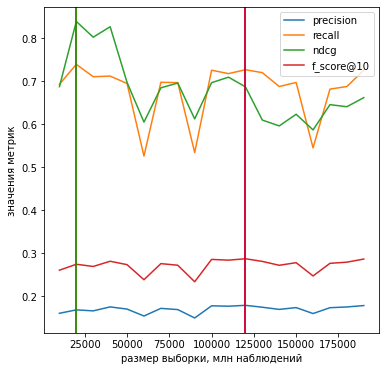

In [182]:
metrics_df = pd.DataFrame.from_dict(metrics)
metrics_df.index = ['precision','recall','ndcg']
metrics_df = metrics_df.T
metrics_df.loc[:,'f_score@10'] = 2* (metrics_df.precision * metrics_df.recall) / (metrics_df.precision + metrics_df.recall)
met_plottt = metrics_df.plot(figsize = (6,6))
met_plottt.set_xlabel('размер выборки, млн наблюдений')
met_plottt.set_ylabel('значения метрик')
plt.axvline(metrics_df.recall.idxmax(), color = 'orange')
plt.axvline(metrics_df.precision.idxmax(), color = 'blue')
plt.axvline(metrics_df.ndcg.idxmax(), color = 'green')
plt.axvline(metrics_df['f_score@10'].idxmax(), color = 'red')

In [ ]:
metrics_df.to_csv('gradboost_metrics.csv')

### обучаем модельку на оптимальном c точки зрения nDCG размере выборки

In [ ]:
res = pd.concat([
        gb_full_old.loc[gb_full_old.target==1], 
        gb_full_old.loc[gb_full_old.target==0].sample(
            n=metrics_df.ndcg.idxmax(),
            replace = False, 
            random_state = 42
        )
    ], axis = 0)

res.loc[:,'value'] = res.heat_count + res.cart_counter*10 + res.wishlist_counter*5

res.ym_client_id = res.ym_client_id.astype('category')

res.brand_categ = res.brand_categ.astype("category")

X_train, y_train = res.drop(columns=['target',
                                     'cart_counter',
                                     'wishlist_counter',
                                     'value']), res.target
lgbm_model = lightgbm.LGBMClassifier(boosting_type='gbdt',
                        learning_rate=0.03,
                        n_estimators= 5000,
                        categorical_feature=['ym_client_id','brand_categ'],
                        n_jobs= -1)
lgbm_model.fit(X_train, y_train)

### смотрим относительную важность фичей в модели

Text(0, 0.5, 'важность признаков')

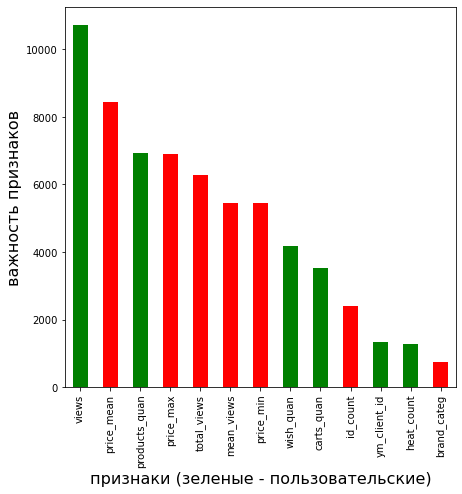

In [183]:
importance_df = pd.DataFrame({
        'feature': lgbm_model.feature_name_,
        'importance': lgbm_model.feature_importances_,
    }).sort_values('importance', ascending=False).replace({
    'Цена_шоурум_mean':'price_mean',
    'Цена_шоурум_max':'price_max',
    'Цена_шоурум_min':'price_min'})
importance_df.loc[:,'color'] = importance_df.feature.replace({'price_mean':'r','total_views':'r','views':'g','price_max':'r','price_min':'r','mean_views':'r','products_quan':'g','wish_quan':'g','id_count':'r','carts_quan':'g','heat_count':'g','ym_client_id':'g','brand_categ':'r'})
importance_df.set_index('feature', inplace = True)
importance_plot = importance_df.importance.plot(kind = 'bar', color = importance_df.color, figsize = (7,7))
importance_plot.set_xlabel('признаки (зеленые - пользовательские)', fontsize = 16)
importance_plot.set_ylabel('важность признаков', fontsize = 16)

# .plot(kind = 'bar')

### сохраняем модельку

In [ ]:
lgbm_model.booster_.save_model(path_to_repo + '/models/'+'lgb_model.txt')

### подгружаем модельку

In [178]:
model = lightgbm.Booster(model_file=path_to_repo + '/models/'+'lgb_model.txt')

In [180]:
model.predict(X_test.sample(n = 100000))

array([3.65868744e-09, 5.52870828e-13, 1.35111618e-11, ...,
       5.18413407e-10, 7.39837255e-09, 1.93481986e-09])

In [ ]:
# preds_ = model.predict(X_test)

gb_test.loc[:,'predicted'] = preds_

recommends = gb_test.pivot(index='ym_client_id', columns='brand_categ', values='predicted')

preferred = gb_test.pivot(index = 'ym_client_id', columns = 'brand_categ', values='target')

# user = '1586839436824718143'
k = 10
precisions = []
recalls = []
ndcgs = []
for user in recommends.index:
    predictions = recommends.loc[user]
    true_values = preferred.loc[user]

    compared = pd.DataFrame([predictions, true_values], index=['preds','true']).T
    compared = compared.sort_values('preds', ascending = False)

    precision = precision_score(compared.true.iloc[:k].map(lambda x: 1 if x > 0 else 0), 
                                compared.preds.iloc[:k].map(lambda x: 1 if x > 0 else 0))
    recall = recall_score(compared.true.iloc[:k].map(lambda x: 1 if x > 0 else 0), 
                          compared.preds.iloc[:k].map(lambda x: 1 if x > 0 else 0))/compared.true.map(lambda x: 1 if x > 0 else 0).sum()
    ndcg = ndcg_score([compared.true.iloc[:k].to_list()], 
                          [compared.preds.iloc[:k].to_list()])
    precisions.append(precision)
    recalls.append(recall)
    ndcgs.append(ndcg)
#         print(user, precision, recall)
recalls = pd.Series(recalls).fillna(0)
#     print(np.mean(precisions), recalls.mean())
[np.mean(precisions), np.mean(recalls), np.mean(ndcgs)]